### Import required packages

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import requests
from area import area
import folium
from folium import plugins
from shapely.geometry import Point, Polygon
import json
import itertools
from math import sin, cos, sqrt, atan2, radians
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from folium.features import DivIcon


### Download and read population data

In [2]:
#!wget https://www.suche-postleitzahl.org/download_files/public/plz_einwohner.csv
einwdf=pd.read_csv("plz_einwohner.csv")
einwdf.head()

,plz,einwohner
0,1067,11957
1,1069,25491
2,1097,14811
3,1099,28021
4,1108,5876


### Download and read neighbourhoods information

In [3]:
#!wget https://www.offenedaten-koeln.de/sites/default/files/2014-01-01_Straßenverzeichnis_Stadtviertel.csv
zuordf=pd.read_csv("2014-01-01_Straßenverzeichnis_Stadtviertel.csv")
zuordf.head()

,strassenschlüssel,strassenname,stadtteilschlüssel,stadtteilname,stadtviertelschlüssel,stadtviertelname,plz,hausnr_ungerade_von,hausnr_ungerade_bis,hausnr_gerade_von,hausnr_gerade_bis
0,1,Aachener Glacis,104,Neustadt/Nord,10407.0,Colonius,50674,0001,0001a,NaN,NaN
1,2,Aachener Str.,102,Neustadt/Süd,10205.0,Komponisten-Viertel,50674,0001,0071,0002,0084
2,2,Aachener Str.,303,Lindenthal,30306.0,Melaten,50931,0075,0327,0186,0188
3,2,Aachener Str.,102,Neustadt/Süd,10208.0,Aachener Weiher,50674,NaN,NaN,0086,0134
4,2,Aachener Str.,303,Lindenthal,,,50931,NaN,NaN,0204,0204


### Download and read geographical data

In [4]:
#!wget -O coordinates.csv https://public.opendatasoft.com/explore/dataset/postleitzahlen-deutschland/download/?format=csv 
coordf=pd.read_csv("coordinates.csv",sep=";")
coordf.head()

,geo_point_2d,geo_shape,note,plz
0,"50.1887724285,8.5159547242","{""type"": ""Polygon"", ""coordinates"": [[[8.474676...",Kronberg im Taunus,61476
1,"48.2017434124,8.5841525734","{""type"": ""Polygon"", ""coordinates"": [[[8.552547...",Villingendorf,78667
2,"48.7639748523,11.2325978452","{""type"": ""Polygon"", ""coordinates"": [[[11.16029...",Bergheim,86673
3,"51.1303193455,6.4483157691","{""type"": ""Polygon"", ""coordinates"": [[[6.421628...",Mönchengladbach,41199
4,"49.8816705909,9.51714833018","{""type"": ""Polygon"", ""coordinates"": [[[9.517068...",Esselbach,97839


### Merge the 3 input tables

In [5]:
kdf=pd.merge(einwdf,zuordf,on=["plz"],how="right")
kdf.head()

,plz,einwohner,strassenschlüssel,strassenname,stadtteilschlüssel,stadtteilname,stadtviertelschlüssel,stadtviertelname,hausnr_ungerade_von,hausnr_ungerade_bis,hausnr_gerade_von,hausnr_gerade_bis
0,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10309.0,Apostel-Viertel,0001,0019,0004,0026
1,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10303.0,Gereons-Viertel,0045,0055,0040,0052
2,50667,4795,74,Alter Markt,103,Altstadt/Nord,10305.0,City,0001,0067,NaN,NaN
3,50667,4795,74,Alter Markt,103,Altstadt/Nord,10306.0,Martins-Viertel,0075,0079,0002,0062
4,50667,4795,91,Am Alten Posthof,103,Altstadt/Nord,10304.0,Neumarkt-Viertel,0001,0005,0002,0008


In [6]:
kdf=pd.merge(kdf,coordf,on="plz",how="left")
kdf.head()

,plz,einwohner,strassenschlüssel,strassenname,stadtteilschlüssel,stadtteilname,stadtviertelschlüssel,stadtviertelname,hausnr_ungerade_von,hausnr_ungerade_bis,hausnr_gerade_von,hausnr_gerade_bis,geo_point_2d,geo_shape,note
0,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10309.0,Apostel-Viertel,0001,0019,0004,0026,"50.9386555045,6.9550698736","{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",Köln
1,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10309.0,Apostel-Viertel,0001,0019,0004,0026,"50.9405013115,6.94405100596","{""type"": ""Polygon"", ""coordinates"": [[[6.943651...",Köln
2,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10303.0,Gereons-Viertel,0045,0055,0040,0052,"50.9386555045,6.9550698736","{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",Köln
3,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10303.0,Gereons-Viertel,0045,0055,0040,0052,"50.9405013115,6.94405100596","{""type"": ""Polygon"", ""coordinates"": [[[6.943651...",Köln
4,50667,4795,74,Alter Markt,103,Altstadt/Nord,10305.0,City,0001,0067,NaN,NaN,"50.9386555045,6.9550698736","{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",Köln


### Clean and prepare data

In [7]:
kdf["latitude"]=kdf["geo_point_2d"].apply(lambda x: float(x.split(",")[0]))
kdf["longitude"]=kdf["geo_point_2d"].apply(lambda x: float(x.split(",")[1]))

In [8]:
kdf["area"]=kdf["geo_shape"].apply(lambda x: area(x))

In [9]:
kdf["einwohner/area"]=kdf["einwohner"]/kdf["area"]

In [10]:
plzgeo=kdf[["plz","latitude","longitude"]].groupby(["plz"],as_index=False).mean()
plzgeo.head()

,plz,latitude,longitude
0,50667,50.939578,6.949560
1,50668,50.949980,6.962841
2,50670,50.950322,6.948592
3,50672,50.942426,6.935930
4,50674,50.932836,6.934087


In [11]:
plzsdf=kdf[["plz","stadtteilname"]].groupby(["plz"], as_index=False).agg({"stadtteilname": lambda x: ", ".join(list(set(x)))})
plzsdf["stadtteilname"]=plzsdf["plz"].astype(str)+": "+plzsdf["stadtteilname"].astype(str)
plzsdf=pd.merge(plzsdf,plzgeo)
plzsdf.head()

,plz,stadtteilname,latitude,longitude
0,50667,"50667: Altstadt/Süd, Altstadt/Nord",50.939578,6.949560
1,50668,"50668: Altstadt/Nord, Neustadt/Nord",50.949980,6.962841
2,50670,"50670: Altstadt/Nord, Neustadt/Nord",50.950322,6.948592
3,50672,"50672: Altstadt/Nord, Neustadt/Nord",50.942426,6.935930
4,50674,"50674: Neustadt/Süd, Altstadt/Süd, Neustadt/Nord",50.932836,6.934087


In [12]:
latitude=np.mean(kdf["latitude"])
longitude=np.mean(kdf["longitude"])
kdf["plz"]=kdf["plz"].astype(str)
map_values=kdf[["plz","einwohner","einwohner/area","area"]].drop_duplicates()
map_values["einwohner/area"]=map_values["einwohner/area"].apply(lambda x: np.log2(x))

### Display the map of the city of Cologne with its inhabitants per postal code

In [13]:
#!wget -O koeln.geo.json "https://public.opendatasoft.com/explore/dataset/postleitzahlen-deutschland/download/?format=geojson&refine.note=Köln&timezone=Europe/Berlin"
# !wget -O germany.geo.json "https://public.opendatasoft.com/explore/dataset/postleitzahlen-deutschland/download/?format=geojson&timezone=Europe/Berlin"

In [14]:
koeln_geo = r'koeln.geo.json' # geojson file

# create a plain world map
koln_map = folium.Map(location=[latitude, longitude], zoom_start=10.5, tiles='Mapbox Bright')

folium.Choropleth(
    geo_data=koeln_geo,
    data=map_values,
    columns=['plz', 'einwohner'],
    key_on='feature.properties.plz', # 'feature.properties.name'
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Inhabitants'
).add_to(koln_map)


# let's start again with a clean copy of the map of San Francisco
sanfran_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
#plzs = plugins.MarkerCluster().add_to(koln_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(plzsdf["latitude"], plzsdf["longitude"], plzsdf["stadtteilname"]):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(koln_map) # plzs

koln_map.save("inhabitants.html")

# display map
koln_map

### Display the map of the city of Cologne with its inhabitants per area size

In [15]:
koeln_geo = r'koeln.geo.json' # geojson file

# create a plain world map
koln_map = folium.Map(location=[latitude, longitude], zoom_start=10.5, tiles='Mapbox Bright')

folium.Choropleth(
    geo_data=koeln_geo,
    data=map_values,
    columns=['plz', 'einwohner/area'],
    key_on='feature.properties.plz', # 'feature.properties.name'
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='log2(inhabitants/area)'
).add_to(koln_map)

koln_map.save("inhabitants.per.area.html")
koln_map

### Zoom in on regions of interest

In [16]:
koeln_geo = r'koeln.geo.json' # geojson file

# create a plain world map
koln_map = folium.Map(location=[latitude, longitude], zoom_start=13, tiles='Mapbox Bright')

folium.Choropleth(
    geo_data=koeln_geo,
    data=map_values,
    columns=['plz', 'einwohner/area'],
    key_on='feature.properties.plz', # 'feature.properties.name'
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='log2(inhabitants/area)'
).add_to(koln_map)

tmp=plzsdf[plzsdf["plz"].isin(["50678","50677","50676","50674","50823","50733"])]
for lat, lng, label, in zip(tmp["longitude"], tmp["latitude"], tmp["plz"]):
   
    folium.map.Marker(
        [lng,lat],
        icon=DivIcon(
            icon_size=(1,1),
            icon_anchor=(0,0),
            html='<div style="font-size: 10pt">%s</div>' % str(label),
            )
        ).add_to(koln_map)
    
tmp=plzsdf[plzsdf["plz"].isin(["50677","50733"])]
for lat, lng, label, in zip(tmp["longitude"], tmp["latitude"], tmp["plz"]):
   
    folium.map.Marker(
        [lng,lat],
        icon=DivIcon(
            icon_size=(1,1),
            icon_anchor=(0,0),
            html='<div style="font-size: 10pt">%s</div>' % str(label),
            )
        ).add_to(koln_map)
    
koln_map.save("inhabitants.per.area.zoom.html")

koln_map

### Get the outer perimeter of the city and spread 400 to 500 queries spots throughout the city

In [17]:
outcoord=kdf[["geo_shape"]].drop_duplicates()
def getMaxXCoor(coords):
    coords = json.loads(coords)
    coords = coords['coordinates'][0]
    coords_1 = [ s[0] for s in coords ]
    coords_2 = [ s[1] for s in coords ]
    coords_1_max=str(max(coords_1))
    coords_1_min=str(min(coords_1))
    coords_2_max=str(max(coords_2))
    coords_2_min=str(min(coords_2))
    results=[coords_1_max,coords_1_min,coords_2_max,coords_2_min]
    results="; ".join(results)
    return results
    
outcoord["max;min"]=outcoord["geo_shape"].apply(lambda x: getMaxXCoor(x))
outcoord[['coords_1_max','coords_1_min','coords_2_max','coords_2_min']]=outcoord["max;min"].str.split('; ',expand=True)
coords_1_max=max(outcoord["coords_1_max"].tolist())
coords_1_min=min(outcoord["coords_1_min"].tolist())
coords_2_max=max(outcoord["coords_2_max"].tolist())
coords_2_min=min(outcoord["coords_2_min"].tolist())

print(coords_1_max,coords_1_min,coords_2_max,coords_2_min)

7.162028 6.7725303 51.0849743 50.830457299999985


In [18]:
nlat=38 # number of bins in latitude

sizelat=float(coords_1_max)-float(coords_1_min)
sizelong=float(coords_2_max)-float(coords_2_min)

addon=sizelat/nlat
new_lats=[float(coords_1_min)+addon/2]
while len( new_lats ) < nlat :
    new_lats.append(new_lats[-1]+addon)
    
nlong=int(sizelong*nlat/sizelat) # number of bins in longitude
print(nlong)

addon=sizelong/nlong
new_longs=[float(coords_2_min)+addon/2]
while len( new_longs ) < nlong :
    new_longs.append(new_longs[-1]+addon)


24


In [19]:
pols=kdf["geo_shape"].unique()

In [20]:
query_coordinates = list(itertools.product(new_lats,new_longs))
query_coordinates = [ list(s) for s in query_coordinates ]
query_coordinates = list(itertools.product(query_coordinates,pols))
#query_coordinates = [ s[0].append(s[1]) for s in query_coordinates ]
query_coordinates = [ list(s) for s in query_coordinates ]
#query_coordinates = [ s[0].append(s[1]) for s in query_coordinates ]
query_coordinates = [ s[0]+[s[1]] for s in query_coordinates ]
query_coordinates = pd.DataFrame(query_coordinates, columns=['latitude','longitude','polygon'])

def checkquerypoint(df):
    lat=df['latitude']
    lng=df["longitude"]
    polygon=df["polygon"]
    
    p1=Point(lat,lng)
    coords = json.loads(polygon)
    coords = coords['coordinates'][0]
    coords = [ tuple(s) for s in coords ]
    poly=Polygon(coords)
    if p1.within(poly):
        return "yes"
    else:
        return "no"


query_coordinates["koeln"]=query_coordinates.apply(checkquerypoint, axis=1)
query_coordinates=query_coordinates[query_coordinates["koeln"]=="yes"][['latitude','longitude',"polygon"]].drop_duplicates()
query_coordinates["n"]=query_coordinates.index.tolist()
query_coordinates["n"]=query_coordinates["n"].astype(str)
query_coordinates.reset_index(inplace=True, drop=True)
print(len(query_coordinates)) #479

479


### Display the location of the query spots on the city map

In [21]:
koeln_geo = r'koeln.geo.json' # geojson file

# create a plain world map
koln_map = folium.Map(location=[latitude, longitude], zoom_start=10.5, tiles='Mapbox Bright')

folium.Choropleth(
    geo_data=koeln_geo,
    data=map_values,
    columns=['plz', 'einwohner'],
    key_on='feature.properties.plz', # 'feature.properties.name'
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Inhabitants'
).add_to(koln_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(query_coordinates["longitude"], query_coordinates["latitude"], query_coordinates["n"]):
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(koln_map) 

koln_map.save("query.coverage.html")

# display map
koln_map

### Calculate the radius of the query so that every cm of the city is queried

In [22]:
R = 6373.0 # earth radius normalization factor
n1="10193"
n2="10241"
lat1 = radians(query_coordinates[query_coordinates["n"]==n1]["latitude"].tolist()[0])
lon1 = radians(query_coordinates[query_coordinates["n"]==n1]["longitude"].tolist()[0])
lat2 = radians(query_coordinates[query_coordinates["n"]==n2]["latitude"].tolist()[0])
lon2 = radians(query_coordinates[query_coordinates["n"]==n2]["longitude"].tolist()[0])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c # distance between 2 closest points (latitude wise)
print(distance)
query_radius=distance/2*1000.00 
print(query_radius)

1.1711346903843278
292.78367259608194


In [23]:
query_coordinates["latitude"]=query_coordinates["latitude"].astype(float)
query_coordinates["longitude"]=query_coordinates["longitude"].astype(float)

query_coordinates["latitude"]=query_coordinates["latitude"].apply(lambda x: round(x, 5))
query_coordinates["longitude"]=query_coordinates["longitude"].apply(lambda x: round(x, 6))

### Query Foursquare

In [24]:
CLIENT_ID = 'BVT1SFWBJO55GRF3FRC5E4ZFYLW0UT3CQHPIMYXAPADQWERL' # your Foursquare ID
CLIENT_SECRET = 'WPPLCOY4SVW1SDCI54VZDEENTZPVZ0DLCXZVQUNYSWT0OGZB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def checkpoint(df):
    lat=df['Venue Latitude']
    lng=df["Venue Longitude"]
    polygon=df["polygon"]
    
    p1=Point(lng,lat)
    coords = json.loads(polygon)
    coords = coords['coordinates'][0]
    coords = [ tuple(s) for s in coords ]
    poly=Polygon(coords)
    if p1.within(poly):
        return "yes"
    else:
        return "no"

def getNearbyVenues(names, latitudes, longitudes, polygon, radius=query_radius, limit=1000):
    
    
    venues_list=[]
    for name, lat, lng, pol in zip(names, latitudes, longitudes, polygon):
        #print(name, lat, lng)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        #print(url)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            #print(results)
            if len(results) > 0:
                # return only relevant information for each nearby venue
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name'],
                    pol) for v in results]
                )
        except:
            print(url)
            sys.stdout.flush()
    if len(venues_list) > 0 :
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category',
                      'polygon']
        #nearby_venues["polygon"]=polygon

        nearby_venues["in plz"]=nearby_venues.apply(checkpoint,axis=1)
        response_size=len(nearby_venues)
        nearby_venues["n response"]=response_size
        
    else:
        nearby_venues=pd.DataFrame(columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category',
                      'polygon',"in plz","n response"])
    
    return(nearby_venues)

koeln_venues= getNearbyVenues(names=query_coordinates['n'],
                                   latitudes=query_coordinates['longitude'],
                                   longitudes=query_coordinates['latitude'],
                                   polygon=query_coordinates['polygon'])

koeln_venues[['Neighborhood', 
              'Neighborhood Latitude', 
              'Neighborhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category',
              "in plz","n response"]].to_csv("koeln_venues.tsv",sep="\t",index=False)

print(len(koeln_venues[koeln_venues["in plz"]=="yes"]))
print(len(koeln_venues[koeln_venues["in plz"]=="no"]))

Your credentails:
CLIENT_ID: BVT1SFWBJO55GRF3FRC5E4ZFYLW0UT3CQHPIMYXAPADQWERL
CLIENT_SECRET:WPPLCOY4SVW1SDCI54VZDEENTZPVZ0DLCXZVQUNYSWT0OGZB
https://api.foursquare.com/v2/venues/explore?&client_id=BVT1SFWBJO55GRF3FRC5E4ZFYLW0UT3CQHPIMYXAPADQWERL&client_secret=WPPLCOY4SVW1SDCI54VZDEENTZPVZ0DLCXZVQUNYSWT0OGZB&v=20180605&ll=50.878179,7.0339&radius=292.78367259608194&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=BVT1SFWBJO55GRF3FRC5E4ZFYLW0UT3CQHPIMYXAPADQWERL&client_secret=WPPLCOY4SVW1SDCI54VZDEENTZPVZ0DLCXZVQUNYSWT0OGZB&v=20180605&ll=50.941808,7.10565&radius=292.78367259608194&limit=1000
975
218


In [25]:
len(koeln_venues["polygon"].unique())

44

In [26]:
kdf.head()

,plz,einwohner,strassenschlüssel,strassenname,stadtteilschlüssel,stadtteilname,stadtviertelschlüssel,stadtviertelname,hausnr_ungerade_von,hausnr_ungerade_bis,hausnr_gerade_von,hausnr_gerade_bis,geo_point_2d,geo_shape,note,latitude,longitude,area,einwohner/area
0,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10309.0,Apostel-Viertel,0001,0019,0004,0026,"50.9386555045,6.9550698736","{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",Köln,50.938656,6.955070,1.269240e+06,0.003778
1,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10309.0,Apostel-Viertel,0001,0019,0004,0026,"50.9405013115,6.94405100596","{""type"": ""Polygon"", ""coordinates"": [[[6.943651...",Köln,50.940501,6.944051,2.656580e+03,1.804952
2,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10303.0,Gereons-Viertel,0045,0055,0040,0052,"50.9386555045,6.9550698736","{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",Köln,50.938656,6.955070,1.269240e+06,0.003778
3,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10303.0,Gereons-Viertel,0045,0055,0040,0052,"50.9405013115,6.94405100596","{""type"": ""Polygon"", ""coordinates"": [[[6.943651...",Köln,50.940501,6.944051,2.656580e+03,1.804952
4,50667,4795,74,Alter Markt,103,Altstadt/Nord,10305.0,City,0001,0067,NaN,NaN,"50.9386555045,6.9550698736","{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",Köln,50.938656,6.955070,1.269240e+06,0.003778


### Clean and merge Foursquare query results 

In [27]:
koeln_venues.head()
koeln_venues=koeln_venues[koeln_venues["in plz"]=="yes"][["polygon","Venue",\
                                                          "Venue Latitude","Venue Longitude",\
                                                          "Venue Category"]]
plz_pol=kdf[["plz","geo_shape","area","einwohner"]].drop_duplicates()
plz_pol=plz_pol.rename(columns={"geo_shape":"polygon"})
koeln_venues=pd.merge(plz_pol,koeln_venues,on=["polygon"],how="inner")

tmp=koeln_venues.drop(["polygon"],axis=1)
tmp.to_csv("koeln_venues.tsv",sep="\t",index=False)

koeln_venues

,plz,polygon,area,einwohner,Venue,Venue Latitude,Venue Longitude,Venue Category
0,50667,"{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",1.269240e+06,4795,Kuchi Mami,50.941390,6.954036,Asian Restaurant
1,50667,"{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",1.269240e+06,4795,Great Wall Restaurant,50.941593,6.954403,Chinese Restaurant
2,50667,"{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",1.269240e+06,4795,Daitokai,50.941400,6.951010,Japanese Restaurant
3,50667,"{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",1.269240e+06,4795,Punto Pasta,50.942301,6.955168,Italian Restaurant
4,50667,"{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",1.269240e+06,4795,Die Vitamin-Oase,50.942348,6.955119,Juice Bar
...,...,...,...,...,...,...,...,...
970,51149,"{""type"": ""Polygon"", ""coordinates"": [[[6.996775...",1.527305e+07,21575,L&D Kantine Postbank,50.911973,7.052520,Food
971,51149,"{""type"": ""Polygon"", ""coordinates"": [[[6.996775...",1.527305e+07,21575,McDonald's,50.911703,7.053370,Fast Food Restaurant
972,51149,"{""type"": ""Polygon"", ""coordinates"": [[[6.996775...",1.527305e+07,21575,Kaiserpalast,50.897519,7.066408,Asian Restaurant
973,51149,"{""type"": ""Polygon"", ""coordinates"": [[[6.996775...",1.527305e+07,21575,Kaiser Palast,50.897360,7.066217,Chinese Restaurant


In [28]:
koeln_venues=koeln_venues.drop_duplicates(subset=["Venue","Venue Latitude","Venue Longitude"])

In [29]:
n_venues=koeln_venues[["plz","Venue"]].groupby(["plz"],as_index=False).count()
n_venues=pd.merge(n_venues,koeln_venues[["plz","area","einwohner"]].drop_duplicates(),on=["plz"],how="inner")
n_venues["venues/area"]=np.log2(n_venues["Venue"]/n_venues["area"])
n_venues["inhabitants/venue"]=np.log2(n_venues["einwohner"]/n_venues["Venue"])

### Dispaly venues results

In [30]:
koeln_geo = r'koeln.geo.json' # geojson file

# create a plain world map
koln_map = folium.Map(location=[latitude, longitude], zoom_start=10.5, tiles='Mapbox Bright')

folium.Choropleth(
    geo_data=koeln_geo,
    data=n_venues,
    columns=['plz', "venues/area"],
    key_on='feature.properties.plz', # 'feature.properties.name'
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='log2(venues/area)'
).add_to(koln_map)


tmp=plzsdf[plzsdf["plz"].isin(["50677","50733"])]
for lat, lng, label, in zip(tmp["longitude"], tmp["latitude"], tmp["plz"]):
   
    folium.map.Marker(
        [lng,lat],
        icon=DivIcon(
            icon_size=(1,1),
            icon_anchor=(0,0),
            html='<div style="font-size: 10pt">%s</div>' % str(label),
            )
        ).add_to(koln_map)
    

# display map
koln_map.save("venues.per.area.html")
koln_map

In [31]:
koeln_geo = r'koeln.geo.json' # geojson file
germany_geo=r'germany.geo.json'

# create a plain world map
koln_map = folium.Map(location=[latitude, longitude], zoom_start=10.5, tiles='Mapbox Bright')

folium.Choropleth(
    geo_data=koeln_geo,
    data=n_venues,
    columns=['plz', "inhabitants/venue"],
    key_on='feature.properties.plz', # 'feature.properties.name'
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='inhabitants/venue'
).add_to(koln_map)  

# display map
koln_map.save("inhabitants.per.venue.html")
koln_map

In [32]:
kdf.head()

,plz,einwohner,strassenschlüssel,strassenname,stadtteilschlüssel,stadtteilname,stadtviertelschlüssel,stadtviertelname,hausnr_ungerade_von,hausnr_ungerade_bis,hausnr_gerade_von,hausnr_gerade_bis,geo_point_2d,geo_shape,note,latitude,longitude,area,einwohner/area
0,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10309.0,Apostel-Viertel,0001,0019,0004,0026,"50.9386555045,6.9550698736","{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",Köln,50.938656,6.955070,1.269240e+06,0.003778
1,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10309.0,Apostel-Viertel,0001,0019,0004,0026,"50.9405013115,6.94405100596","{""type"": ""Polygon"", ""coordinates"": [[[6.943651...",Köln,50.940501,6.944051,2.656580e+03,1.804952
2,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10303.0,Gereons-Viertel,0045,0055,0040,0052,"50.9386555045,6.9550698736","{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",Köln,50.938656,6.955070,1.269240e+06,0.003778
3,50667,4795,38,Albertusstr.,103,Altstadt/Nord,10303.0,Gereons-Viertel,0045,0055,0040,0052,"50.9405013115,6.94405100596","{""type"": ""Polygon"", ""coordinates"": [[[6.943651...",Köln,50.940501,6.944051,2.656580e+03,1.804952
4,50667,4795,74,Alter Markt,103,Altstadt/Nord,10305.0,City,0001,0067,NaN,NaN,"50.9386555045,6.9550698736","{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",Köln,50.938656,6.955070,1.269240e+06,0.003778


In [33]:
koeln_venues.head()

,plz,polygon,area,einwohner,Venue,Venue Latitude,Venue Longitude,Venue Category
0,50667,"{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",1.269240e+06,4795,Kuchi Mami,50.941390,6.954036,Asian Restaurant
1,50667,"{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",1.269240e+06,4795,Great Wall Restaurant,50.941593,6.954403,Chinese Restaurant
2,50667,"{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",1.269240e+06,4795,Daitokai,50.941400,6.951010,Japanese Restaurant
3,50667,"{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",1.269240e+06,4795,Punto Pasta,50.942301,6.955168,Italian Restaurant
4,50667,"{""type"": ""Polygon"", ""coordinates"": [[[6.939811...",1.269240e+06,4795,Die Vitamin-Oase,50.942348,6.955119,Juice Bar


### Prepare venues data for k-Means clustering

In [47]:
forModel=koeln_venues[["plz","einwohner","area","Venue Category"]]
forModel=pd.merge(forModel,n_venues[["plz","venues/area"]],on=["plz"],how="outer")
forModel["einwohner"]=np.log2(forModel["einwohner"]/forModel["area"])
forModel=forModel.drop(["area"],axis=1)
forModel.reset_index(inplace=True, drop=True)
forModel_onehot = pd.get_dummies(forModel[['Venue Category']], prefix="", prefix_sep="")
forModel=forModel.drop(["Venue Category"],axis=1)
forModel=pd.concat([forModel[["plz"]],forModel_onehot],axis=1)
forModel = forModel.groupby('plz').mean().reset_index()
X = forModel.drop(["plz"],axis=1)

### Test range of cluster numbers

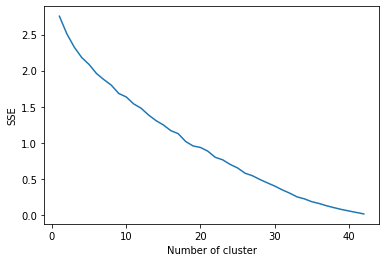

In [48]:
sse = {}
for k in range(1, 43):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()    

### k-Means clustering

In [49]:
kclusters=3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)
forModel.insert(0, 'Cluster Labels', kmeans.labels_)
koelnclusters=pd.merge( forModel[["plz","Cluster Labels"]], kdf[["plz","latitude","longitude"]].drop_duplicates() )

In [50]:
koeln_geo = r'koeln.geo.json' # geojson file

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

koln_map = folium.Map(location=[latitude, longitude], zoom_start=10.5, tiles='Mapbox Bright')

folium.Choropleth(
    geo_data=koeln_geo,
    data=n_venues,
    columns=['plz', "venues/area"],
    key_on='feature.properties.plz', # 'feature.properties.name'
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='log2(venues/area)'
).add_to(koln_map)


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(koelnclusters['latitude'], koelnclusters['longitude'], \
                                  koelnclusters['plz'], koelnclusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(koln_map)



# # let's start again with a clean copy of the map of San Francisco
# sanfran_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# # instantiate a mark cluster object for the incidents in the dataframe
# #plzs = plugins.MarkerCluster().add_to(koln_map)

# # loop through the dataframe and add each data point to the mark cluster
# for lat, lng, label, in zip(query_coordinates["longitude"], query_coordinates["latitude"], query_coordinates["n"]):
#     folium.CircleMarker(
#         [lat, lng],
#         radius=2,
#         popup=label,
#         color='blue',
#         fill=True,
#         fill_color='#3186cc',
#         fill_opacity=0.7,
#         parse_html=False).add_to(koln_map) 
    

# display map
koln_map.save("venues.categories.clusters.html")
koln_map

In [51]:
koelnclusters.head()

,plz,Cluster Labels,latitude,longitude
0,50667,1,50.938656,6.955070
1,50667,1,50.940501,6.944051
2,50668,0,50.949980,6.962841
3,50670,0,50.950322,6.948592
4,50672,0,50.942426,6.935930


In [52]:
forModel.head()

,Cluster Labels,plz,ATM,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Trattoria/Osteria,Travel Agency,Tunnel,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Water Park,Waterfront,Wine Shop,Zoo Exhibit
0,1,50667,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.125000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0,50668,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0,50670,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0,50672,0.0,0.0,0.0,0.0,0.0,0.02439,0.0,0.000000,...,0.02439,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0,50676,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.057143,...,0.00000,0.0,0.0,0.0,0.0,0.028571,0.028571,0.0,0.0,0.0


### Difference between Nippes (50733) and other trendy city areas

In [53]:
cluster=forModel[forModel["Cluster Labels"]==0].groupby(["Cluster Labels"],as_index=False).mean()
cluster

,Cluster Labels,ATM,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trattoria/Osteria,Travel Agency,Tunnel,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Water Park,Waterfront,Wine Shop,Zoo Exhibit
0,0,0.0,0.001742,0.003484,0.001742,0.003484,0.007074,0.0,0.01165,0.007695,...,0.011929,0.001553,0.005952,0.006097,0.0,0.003971,0.007993,0.001553,0.0,0.0


In [55]:
Nippes=forModel[forModel["plz"]=="50733"].groupby(["Cluster Labels"],as_index=False).mean()
diff=cluster.transpose()-Nippes.transpose()
diff=diff[1:]
diff=diff.sort_values(by=[0],ascending=False)
diff.columns=["score"]
print("top 20 needs\n", diff[:20])
print("\ntop 20 trends in Nippes\n", diff[-20:])

top 20 needs
                          score
Hotel                 0.072479
Bar                   0.028149
Italian Restaurant    0.026282
Nightclub             0.021669
Restaurant            0.021558
German Restaurant     0.016263
Pizza Place           0.015863
Pub                   0.013065
Burger Joint          0.012921
Spanish Restaurant    0.012302
Snack Place           0.012040
Trattoria/Osteria     0.011929
Asian Restaurant      0.011650
Austrian Restaurant   0.011111
French Restaurant     0.009844
Tapas Restaurant      0.009403
Automotive Shop       0.009354
Theater               0.009354
Fast Food Restaurant  0.009327
Water Park            0.007993

top 20 trends in Nippes
                                score
Breakfast Spot             -0.017728
Café                       -0.018584
Cocktail Bar               -0.018651
Modern European Restaurant -0.020833
Flea Market                -0.021879
Organic Grocery            -0.022067
Music Venue                -0.022067
Bookstore    